In [175]:
#iimports
import glob
from math import e, gamma
import os
from pathlib import Path
from turtle import color
from librosa import feature
import pandas as pd
import librosa
import datetime
import time
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
# import scikitplot as skplt

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from joblib import dump, load
from statistics import mean
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import os

In [176]:
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


SPLITTING THE AUDIOFILE

In [ ]:
import soundfile as sf

audiorec=[]
count=0
def split(filez):
    
    split_into = 5
    samples_splitted = []
    current_step = 0
    i=0
    X,sample_rate = librosa.load(filez, res_type="kaiser_best" )
    while current_step < len(X):
        samples_splitted.append(X[current_step: split_into * sample_rate ])
        sf.write(f"set22-{i} outfile.wav", samples_splitted[i], sample_rate)
        current_step = split_into * sample_rate
        i+=1

        split_into += 5
    
     

In [ ]:
split('audiofile')

CREATING LIST FOR SPLIT AUDIOFILE DATA

In [ ]:
path= 'splitaudio/'
files = os.listdir(path)
audiofile = []
for filename in glob.glob(os.path.join(path, '*.wav')):
    data, samplerate = librosa.load(filename, res_type='kaiser_best')
    audiofile.append(data)

print(len(audiofile))    

In [178]:
NO_PER_LABEL =NO_PER_LABEL =[65, 60, 60, 60, 61, 60, 60, 60, 60, 61, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 60, 61, 60, 60]
readings = [0.1, 2.5, 4.6, 6.6, 5.5, 5, 3.2, 0.5, 0.1, 1.5, 0.3, 2, 3.5, 3.5, 1.5, 3.5, 5.5, 5.5, 1.5, 1, 1, 0.4, 0.09, 1.8, 0.5, 0.08]
label_list=[]
for i,reading in zip(NO_PER_LABEL, readings):
    count=0
    while count <= i:
        label_list.append(reading)
        count+=1
print(len(label_list))

1595


In [173]:
def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    #file_name = os.path.join(os.path.abspath('voice')+'/'+str(files.file))
    #file_name = files.audio_files
    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    #X, sample_rate = librosa.load(file_name, res_type='kaiser_best')     

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=files, sr=22050, n_mfcc=12).T,axis=0) ## DIGEST MORE ON THE MFCC
    # mfccs = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=40))
    # mfccs = librosa.feature.chroma_stft(y=X, sr=sample_rate)
    # mfccs = librosa.lpc(y=X, order=2)
    
    # We add also the classes of each file as a label at the end
    #label = files.labels

    return mfccs

In [ ]:
mfcc_list = []
for file in audiofile:
    mfcc_list.append(extract_features(file))
print(len(mfcc_list))

In [ ]:
np.savez_compressed("rain_dataset", mfcc=mfcc_list, labels=label_list )

In [179]:
loaded = np.load('/content/drive/MyDrive/rain_dataset.npz')

In [9]:
print(len(loaded['mfcc']))

1595


In [10]:
X = loaded["mfcc"]

In [11]:
X= X.flatten()

In [12]:
len(X)

19140

In [13]:

from itertools import islice

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

In [14]:
me = chunk(X, 288)
label_list = chunk(label_list, 24)

In [15]:
me = list(me)
label_list = list(label_list)

In [16]:
new_labels = []
for val in label_list:
    new_labels.append(val[0])

In [17]:
data = np.array(me, dtype=object)

In [18]:
newme =[]
for dat in me[:-1]:
    newme.append(np.array(dat, dtype=np.float64))

In [19]:
newme = np.array(newme)

In [20]:
len(newme)

66

In [21]:
newme.shape

(66, 288)

In [22]:
len(new_labels)

67

In [23]:
scaler = StandardScaler()
# good_list_scaled = (scaler.fit_transform(good_list))
good_list_scaled = (scaler.fit_transform(newme))

TRAINING THE MODEL USING SVR(POLY)

In [225]:
## try a Deep Neural Network
X = np.array(loaded['mfcc'])
#X = good_list_scaled
Y = label_list
#Y =  new_labels[:-1]
# Splitting dataset into train and test set

X_train, X_test, Y_train, Y_test = train_test_split(
X, Y, test_size = 1/5, random_state = 0, shuffle=True)
model = SVR(kernel="poly")
# model = RandomForestRegressor(max_depth=None, random_state=0)
model.fit( X_train, Y_train )

# Prediction on test set
print("LEN OF DATA ->",len(X_test))
Y_pred = model.predict( X_test )

#print( "Predicted values ", np.round( Y_pred, 2 ) )

#print( "Real values	 ", Y_test[:30] )

#print( " Coefficients of the LR ",  model.coef_, model.intercept_ )



mse = mean_absolute_percentage_error(Y_test, Y_pred) * 100 ##( |ypred - ytrue|/ytrue * 100)

print(' The Mean absolute percentage Error is ->', mse, '%')

LEN OF DATA -> 319
 The Mean absolute percentage Error is -> 138.7073198432046 %


TRAINING THE MODEL USING XGB-REGRESSOR

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
# Instantiate gb
gb = GradientBoostingRegressor(max_depth=4,
                               n_estimators=200,
                               random_state=2)
gb.fit( X_train, Y_train )

# Predict test set labels
y_pred = gb.predict(X_test)

print( "Predicted values ", np.round( Y_pred[:3], 2 ) )

print( "Real values	 ", Y_test[:3] )

#print( " Coefficients of the LR ",  model.coef_, model.intercept_ )



mse = mean_absolute_percentage_error(Y_test, Y_pred) * 100 ##( |ypred - ytrue|/ytrue * 100)

print(' The Mean absolute percentage Error is ->', mse, '%')

Predicted values  [2.55 2.09 2.  ]
Real values	  [5.5, 0.3, 2]
 The Mean absolute percentage Error is -> 106.69729539722607 %


MODEL TRAINING USING DEEP NEURAL NETWORK

In [226]:

from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling1D
import tensorflow as tf
from keras.layers import Flatten

In [227]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape(y_true, y_pred):
    return (K.mean((K.abs(y_pred - y_true))/y_true) * 100)

In [228]:
# dnn_neural = Sequential([
#     tf.keras.layers.Input(shape = X_train.shape[1:]),
#     # Dense(10, activation='softsign'),
#     # Dense(6, activation='softsign'),
#     Dense(3, activation='softsign'),
#     Dense(1, activation='sigmoid')
# ])
NN_model = Sequential()
NN_model.add(Dense(6, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

# The Hidden Layers :
# NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
# NN_model.add(Dense(6, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(3, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 6)                 78        
                                                                 
 dense_37 (Dense)            (None, 3)                 21        
                                                                 
 dense_38 (Dense)            (None, 1)                 4         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [229]:
# history = dnn_neural.fit(X_train, np.array(Y_train), validation_split = 0.2,batch_size=32, epochs=5)
history = NN_model.fit(X_train, np.array(Y_train), validation_split = 0.2,batch_size=32, epochs=500)

Epoch 1/500
32/32 [==============================] - 1s 6ms/step - loss: 2.2009 - mean_absolute_error: 2.2009 - val_loss: 2.2426 - val_mean_absolute_error: 2.2426
Epoch 2/500
32/32 [==============================] - 0s 2ms/step - loss: 1.9936 - mean_absolute_error: 1.9936 - val_loss: 1.9290 - val_mean_absolute_error: 1.9290
Epoch 3/500
32/32 [==============================] - 0s 3ms/step - loss: 1.7006 - mean_absolute_error: 1.7006 - val_loss: 1.4746 - val_mean_absolute_error: 1.4746
Epoch 4/500
32/32 [==============================] - 0s 2ms/step - loss: 1.2017 - mean_absolute_error: 1.2017 - val_loss: 1.0051 - val_mean_absolute_error: 1.0051
Epoch 5/500
32/32 [==============================] - 0s 3ms/step - loss: 0.8541 - mean_absolute_error: 0.8541 - val_loss: 0.8548 - val_mean_absolute_error: 0.8548
Epoch 6/500
32/32 [==============================] - 0s 3ms/step - loss: 0.7473 - mean_absolute_error: 0.7473 - val_loss: 0.8452 - val_mean_absolute_error: 0.8452
Epoch 7/500
32/32 [===

In [230]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

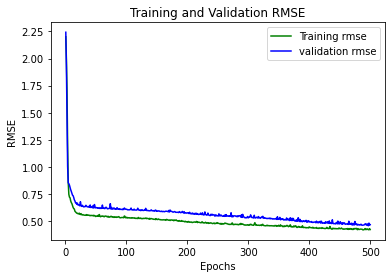

In [231]:
import matplotlib.pyplot as plt

loss_train = history.history['mean_absolute_error']
loss_val = history.history['val_mean_absolute_error']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training rmse')
plt.plot(epochs, loss_val, 'b', label='validation rmse')
plt.title('Training and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [232]:
# Predict test set labels
y_pred = NN_model.predict(X_test)

print("NN predictions ->",y_pred[:, 0])
# print( "Predicted values ", np.round( Y_pred[:30], 2 )/10 )



print( "Real values	 ", Y_test[:30]  )

#print( " Coefficients of the LR ",  model.coef_, model.intercept_ )



mse = mean_absolute_percentage_error(Y_test, y_pred, multioutput="raw_values") * 100 ##( |ypred - ytrue|/ytrue * 100)

print(' The Mean absolute percentage Error is ->', mse, '%')

10/10 [==============================] - 0s 2ms/step
NN predictions -> [2.0881295  5.982083   1.3506196  0.46821007 1.2475388  6.178735
 0.09977883 0.09977883 0.85726476 2.1596076  5.6165843  0.36494443
 4.601857   0.26589906 0.37823856 1.7764688  0.17242056 5.5549536
 0.4972887  0.09977883 0.7381842  0.09977883 0.09977883 1.0827017
 6.706588   2.8741832  3.5463333  2.846189   0.09977883 2.0817833
 1.4290254  3.6720645  3.5954258  0.09977883 1.7718275  0.8541309
 1.7924163  4.9252543  0.09977883 1.2037785  2.024378   1.0271807
 1.1571496  4.9027123  1.9760303  5.1131873  0.8418202  0.5340255
 4.0086555  0.55076826 2.7534528  0.09977883 0.09977883 1.500011
 2.0887372  4.477001   6.35626    0.21993269 1.2629087  0.82647955
 3.3089063  0.99051124 5.9469624  2.1170573  0.09977883 0.21297756
 0.8171994  2.8104858  2.5098677  2.531191   4.637383   0.30357903
 0.8893074  0.09977883 0.3639739  0.1455584  1.1112504  3.6202266
 1.6006522  0.09977883 2.9238145  1.6957848  2.2511015  5.426469
 6.4

In [233]:
base_rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

In [234]:
base_rmse

0.6212357765676298

CONVOLUTIONAL NEURAL NETWORK

In [277]:
X_train = X_train.reshape( (len(X_train), 12, 1))

In [278]:
X_test = X_test.reshape( (len(X_test), 12, 1))

In [279]:
X_train.shape

(1276, 12, 1)

In [280]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], np.array(Y_train).shape[0]

In [281]:
model = Sequential()
model.add(Conv1D(filters=6, kernel_size=3, activation='softsign', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=4, kernel_size=3, activation='softsign'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(8, activation='relu'))
# model.add(Dense(1, activation='softmax'))
model.add(Dense(6,  kernel_initializer='normal', activation='softsign')),
model.add(Dense(3,  kernel_initializer='normal', activation='softsign')),
model.add(Dense(1, activation='sigmoid'))
model.compile(loss=rmse, optimizer='adam')

In [282]:
history = model.fit(X_train, np.array(Y_train), validation_split = 0.2, epochs=500,)

Epoch 1/500
32/32 [==============================] - 1s 8ms/step - loss: 2.6987 - val_loss: 2.7848
Epoch 2/500
32/32 [==============================] - 0s 3ms/step - loss: 2.6695 - val_loss: 2.7372
Epoch 3/500
32/32 [==============================] - 0s 3ms/step - loss: 2.6216 - val_loss: 2.6887
Epoch 4/500
32/32 [==============================] - 0s 3ms/step - loss: 2.5777 - val_loss: 2.6525
Epoch 5/500
32/32 [==============================] - 0s 3ms/step - loss: 2.5544 - val_loss: 2.6258
Epoch 6/500
32/32 [==============================] - 0s 3ms/step - loss: 2.5354 - val_loss: 2.6053
Epoch 7/500
32/32 [==============================] - 0s 3ms/step - loss: 2.5044 - val_loss: 2.5889
Epoch 8/500
32/32 [==============================] - 0s 3ms/step - loss: 2.5012 - val_loss: 2.5756
Epoch 9/500
32/32 [==============================] - 0s 3ms/step - loss: 2.4972 - val_loss: 2.5646
Epoch 10/500
32/32 [==============================] - 0s 3ms/step - loss: 2.4864 - val_loss: 2.5554
Epoch 11/

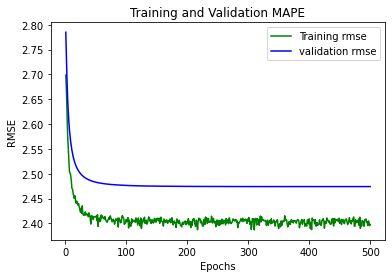

In [283]:
import matplotlib.pyplot as plt

loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,len(loss_train)+1)
plt.plot(epochs, loss_train, 'g', label='Training rmse')
plt.plot(epochs, loss_val, 'b', label='validation rmse')
plt.title('Training and Validation MAPE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [284]:
# Predict test set labels
y_pred = model.predict(X_test)

print( " CNN Predicted values ", np.round( Y_pred[:30], 2 ) )

y_pred =y_pred[:, 0] 
print( "Real values	 ", Y_test[:30] )

#print( " Coefficients of the LR ",  model.coef_, model.intercept_ )



mse = mean_absolute_percentage_error(Y_test, y_pred) *100 ##( |ypred - ytrue|/ytrue * 100)

print(' The Mean absolute percentage Error is ->', mse, '%')

10/10 [==============================] - 0s 2ms/step
 CNN Predicted values  [ 3.04  3.74  2.69  0.67  2.1   3.65  0.69 -0.57 -0.53  2.86  3.53  0.58
  3.53  1.05  0.    2.96 -0.61  3.49  0.52  0.42  0.04  0.57  0.92  1.52
  3.67  3.31  3.59  3.28  0.21  2.57]
Real values	  [1.5, 5.5, 1.5, 0.5, 1.5, 5.5, 0.1, 0.08, 1, 3.2, 5.5, 0.5, 3.5, 0.1, 0.5, 1.5, 0.09, 5.5, 0.5, 0.1, 1, 0.1, 0.4, 1, 6.6, 1.8, 3.5, 1.8, 0.1, 2]
 The Mean absolute percentage Error is -> 225.281251506089 %


In [235]:
NN_model.save('./saved_models/baseline_model.h5')

In [236]:
import os
os.path.getsize('./saved_models/baseline_model.h5')

33480

In [237]:
# Installing with the `--upgrade` flag ensures you'll get the latest version.
!pip install tensorflow-model-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


PRUNING

In [249]:
import tensorflow_model_optimization as tfmot

In [250]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

In [251]:
epochs = 30
batch_size = 32
end_step = 200

In [252]:
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50, final_sparsity=0.80, begin_step=0, end_step=end_step)
}

In [253]:
pruned_model = prune_low_magnitude(NN_model,**pruning_params)

In [254]:
pruned_model.compile(optimizer='rmsprop',loss='mse')

In [255]:
import tempfile
log_dir = tempfile.mkdtemp()
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=log_dir)
]

In [256]:
pruned_model.fit(x=X_train,y=np.array(Y_train),epochs=epochs,validation_data=(X_test,np.array(Y_test)),callbacks=callbacks) 

Epoch 1/30
 1/40 [..............................] - ETA: 1:00 - loss: 1.6799

40/40 [==============================] - 2s 7ms/step - loss: 2.1650 - val_loss: 1.6170
Epoch 2/30
40/40 [==============================] - 0s 3ms/step - loss: 1.5164 - val_loss: 1.2997
Epoch 3/30
40/40 [==============================] - 0s 3ms/step - loss: 2.2597 - val_loss: 2.9350
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9947 - val_loss: 2.9372
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9954 - val_loss: 2.9359
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9932 - val_loss: 2.9331
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9915 - val_loss: 2.9325
Epoch 8/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9898 - val_loss: 2.9358
Epoch 9/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9880 - val_loss: 2.9361
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 2.9873 - val_loss: 2.9376
Epoch 11/30
40/40 [===========

In [257]:
predictions=pruned_model.predict(X_test)

10/10 [==============================] - 0s 3ms/step


In [258]:
pruned_rmse = np.sqrt(mean_squared_error(Y_test,predictions))

In [259]:
print("pruned_rmse -> ", pruned_rmse)

pruned_rmse ->  1.712541272256738


In [260]:
model_for_export = tfmot.sparsity.keras.strip_pruning(pruned_model)
model_for_export.save('./saved_models/pruned_model.h5')

In [261]:
pruned_model_size = os.path.getsize('./saved_models/pruned_model.h5')

In [262]:
baseline_model_size = os.path.getsize('./saved_models/baseline_model.h5')

In [263]:
print(pruned_model_size)

18264


In [264]:
print(baseline_model_size)

33480


In [265]:
print(pruned_rmse)

1.712541272256738


In [266]:
print(base_rmse)

0.6212357765676298


In [268]:
start = time.time()

for _ in range(100):
    predictions = model_for_export.predict(X_test, verbose=0)
end = time.time()
pruned_pred_time = end-start
print(f'Pruned/Striped Prediction time: {end-start}')

start = time.time()
for _ in range(100):
    predictions = NN_model.predict(X_test, verbose=0)
end = time.time()
baseline_pred_time = end-start
print(f'Baseline Prediction time: {end-start}')

Pruned/Striped Prediction time: 6.105374097824097
Baseline Prediction time: 6.060596466064453


QUANTIZATION

In [269]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_and_pruned_tflite_model = converter.convert()

with open('./saved_models/pruned_quantized_model.tflite', 'wb') as f:
  f.write(quantized_and_pruned_tflite_model)

In [270]:
pruned_quantized_model_size = os.path.getsize('./saved_models/pruned_quantized_model.tflite')

In [271]:
print(baseline_model_size)

33480


In [272]:
print(pruned_model_size)

18264


In [273]:
print(pruned_quantized_model_size)

2320


In [274]:
# Load TFLite model and allocate tensors.
# How to predict with tfLite mode [Unzipping]
interpreter = tf.lite.Interpreter(model_content=quantized_and_pruned_tflite_model)
interpreter.allocate_tensors()# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
predictions = []
for i in range(len(X_test)):
    input_data = X_test[i]
    input_data = np.expand_dims(input_data, axis=0).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predictions.append(output_data)

In [275]:
predictions = np.array(predictions).reshape(-1, 1)
pruned_quantized_rmse = np.sqrt(mean_squared_error(Y_test, predictions))
print(f'RMSE: {np.sqrt(mean_squared_error(Y_test, predictions))}')

RMSE: 1.7125412567078007


In [221]:
print(base_rmse)

1.597258753124207


In [222]:
print(pruned_rmse)

1.5447936887265623


In [223]:
print(pruned_quantized_rmse)

1.5450361501845076
